# What Does the Trips Dataset Tell us About Rideshare Usage in Chicago?



Since November 2018, rideshare providers (Lyft, Uber, etc) operating in Chicago are required by ordinance to submit periodic data reports with basic rideshare information to the City.  The main [Trips dataset](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p) includes information about individual rides, including starting and ending times and locations, fares and tips, and whether the rides were pooled.  The Trips data are anonymized, so trip starting and ending locations are generalized to the nearest census tract, and drivers cannot be linked to particular rides they provided.  The currently available dataset goes through June 2019, however the portion used for this exercise goes from November 2018 through March 2019.

To prepare for the analyses and visualizations in this notebook, the Trips data was cleaned, aggregated, and enriched with climate and census data.  Please note: the aggregated datasets are derived from a 5% sample of the entire Trips dataset, so total ride counts presented here would need to be multiplied by 20 to give more accurate population counts.  

In [1]:
%config IPCompleter.greedy=True

In [2]:
import csv
import os
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as ctx #for basemaps
import ipywidgets as widgets


In [3]:
plt.rcParams['figure.figsize'] = [15, 5]

In [4]:
#load pickled/munged data 
datadir=r'/Users/rtaylor/Desktop/Springboard/DataSets/Rideshare'

#5% sample of rides from raw data
ridesdf=pd.read_pickle(os.path.join(datadir,'sampled_reformatted_df'))

#data aggregated hourly by pickup census tract, with census info, weather and geography
daily_df=pd.read_pickle(os.path.join(datadir,'agg_daily_all_gdf'))
daily_gdf = gpd.GeoDataFrame(daily_df, geometry='geometry')

#data aggregated daily by pickup census tract, with geography
agg_hourly_all=pd.read_pickle(os.path.join(datadir,'agg_hourly_all_gdf'))
hourly_gdf= gpd.GeoDataFrame(agg_hourly_all, geometry='geometry')


## Question 1:  What are the relationships between ride pricing, duration and distance travelled?
### Approach:  Look at patterns in scatter plots of fare as a function of distance and time.  

Notes:
* To improve performance, this analysis was performed on a smaller subset of data (0.5% of original dataset)
* Pooled trips have also been removed, since they are likely to use a different pricing model

In [5]:
#Subset data and derive Trip Minutes field
ridesdf_samp=ridesdf.sample(frac=0.1).sort_values('TripMiles')
ridesdf_samp=ridesdf_samp.loc[ridesdf_samp.TripsPooled==1]
ridesdf_samp['TripMin']=ridesdf.TripSeconds/60

Text(0.5, 1.0, 'Fare vs Duration')

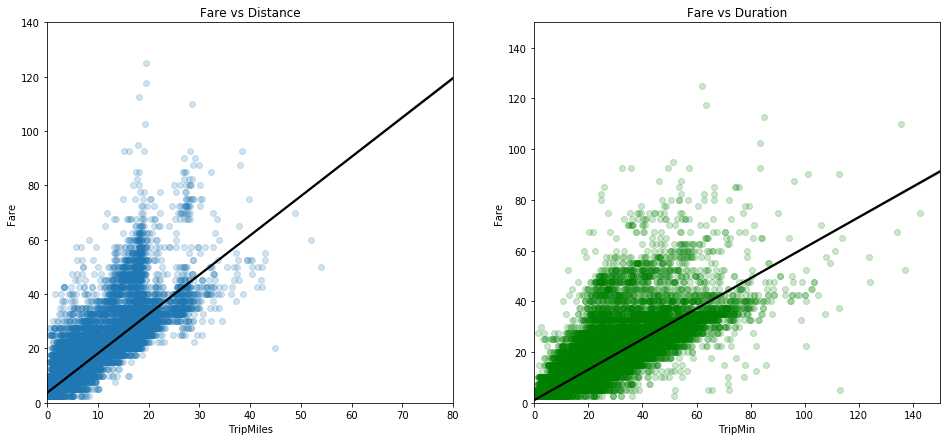

In [6]:
#Generate seaborn regplots of distance and fare, and duration and fare
f, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.regplot(x='TripMiles',y='Fare',data=ridesdf_samp,line_kws={'color':'black'},scatter_kws={'alpha':0.2},ax=axes[0])
sns.regplot(x='TripMin',y='Fare',data=ridesdf_samp,line_kws={'color':'black'},scatter_kws={'alpha':0.2,'color':'green'},ax=axes[1])
axes[0].set_xlim([0,80])
axes[0].set_ylim([0,140])
axes[1].set_xlim([0,150])
axes[1].set_ylim([0,150])
axes[0].set_title('Fare vs Distance')
axes[1].set_title('Fare vs Duration')

### What did we learn?
* For unpooled rides, there are correlations between ride distance, ride duration, and pricing but they are not clear cut
* The relationship between fare and distance appears to have a floor (i.e. minimum rate per mile)
* There is more spread in fares when looking at the relationship bewteen fare and duration compared to fare and distance, so the pricing model appears more likely to be drived from rate per mile.  Rides of the same distance can have a large range of travel times due to road types used, traffic, etc.
* Most rides are less than 40 miles, though the pricing can vary widely for rides of the same distance.  This distance is consistent with the size of Chicago (~30 miles from north to south).  Rides that originate/terminate outside Chicago aren't included in the dataset.


## Question 2:  What do we know about tipping?  Do riders tip drivers, and what percentage is typical?
### Approach:  
* Calculate tip percentage (tip/fare)
* Bin tip % into categories, and create a bar plot (similar to a histogram) to look at frequency of different percent ranges
* Look at plots of tip vs fare, does tip generally increase with fare?
* Plot tip % versus trip time:  is there a relationship between tipping percent and trip duration?



In [7]:
#Look at tip as percent of fare, does it vary
ridesdf_samp['TipPct']=ridesdf_samp.apply(lambda x: x.Tip/x.Fare,axis=1)
#Create ranges of tip percentages and plot bar chart
tip_pct_ranges = pd.cut(ridesdf_samp['TipPct'], bins=[0,0.001,0.05,0.1,0.20,0.5,1,1000],right=False,include_lowest=True,labels=['None','0-5%','5-10%','10-20%','20-50%', '50-100%','>100%'] )
print('Distribution of tip percentages over {} rides'.format(tip_pct_ranges.shape[0]))
tip_pct_ranges.value_counts(sort=False)


Distribution of tip percentages over 127251 rides


None       102042
0-5%           87
5-10%        1105
10-20%       5481
20-50%      15578
50-100%      2193
>100%         765
Name: TipPct, dtype: int64

Text(0.5, 0, 'Range of tips as % of Fare')

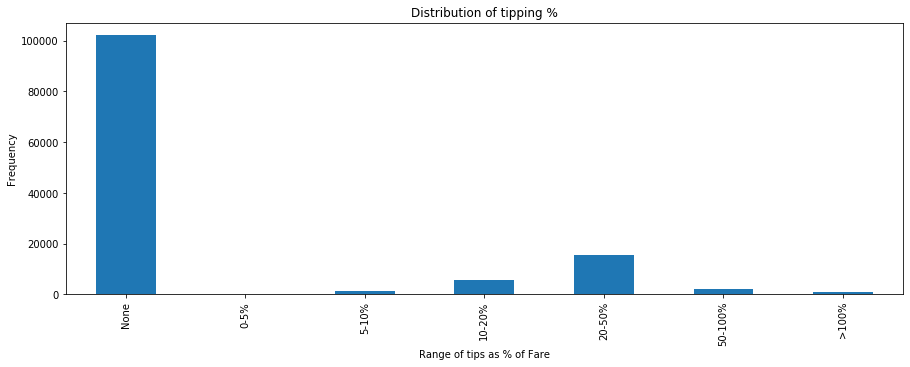

In [8]:
tip_pct_ranges.value_counts(sort=False).plot.bar()
ax=plt.gca()
ax.set_title('Distribution of tipping %')
ax.set_ylabel('Frequency')
ax.set_xlabel('Range of tips as % of Fare')

Text(0.5, 1.0, 'Tipping by Fare')

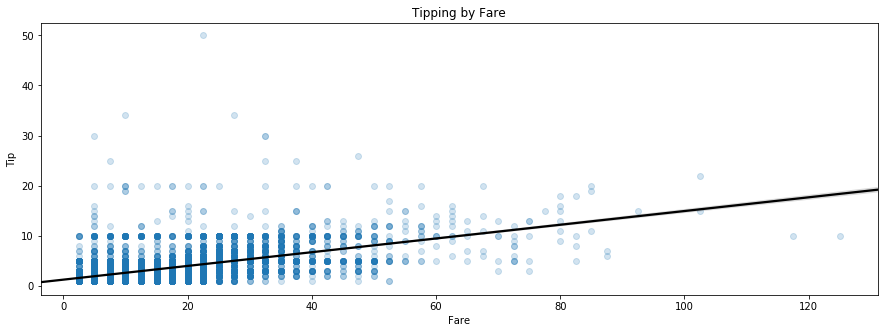

In [9]:
#For riders who tip, does tip correlate with fare?
sns.regplot(x='Fare',y='Tip',data=ridesdf_samp.loc[ridesdf_samp.Tip>0],line_kws={'color':'black'},scatter_kws={'alpha':0.2})
plt.gca().set_title('Tipping by Fare')

/Users/rtaylor/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


Text(0.5, 1.0, 'Tipping Percent by Fare, with zero tips')

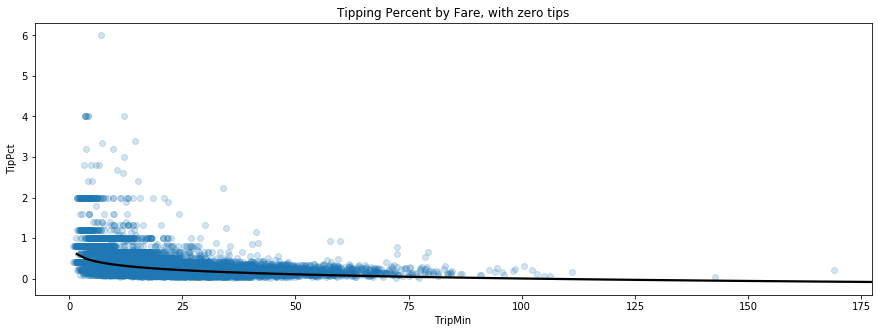

In [10]:
#Does tip percent correlate with ride duration?  Looks like the biggest tip percent comes with shorter rides
sns.regplot(x='TripMin',y='TipPct',data=ridesdf_samp.loc[ridesdf_samp.Tip>0],line_kws={'color':'black'},scatter_kws={'alpha':0.2},logx=True)
plt.gca().set_title('Tipping Percent by Fare, with zero tips')

### What did we learn?
* Most riders don't tip the driver!
* However, those who do tip tend to be generous.
* Tips generally increase with fare, though there is alot of variation.
* For rides where the passengers tipped, the biggest tip percents are associated with short rides 

## Question 3:  What are the spatio-temporal patterns in this dataset?  Where do most rides originate and terminate?  
### Approach: aggregate all rides over starting and ending census tracts and generate chloropleth maps to illustrate which tracts have the most rides

In [11]:
PUusage=ridesdf_samp.groupby('PUCensusTract').size()
DOusage=ridesdf_samp.groupby('DOCensusTract').size()
usage_df=pd.concat([PUusage,DOusage],axis=1,sort=True)
usage_df.columns=['PU_usage','DO_usage']

/Users/rtaylor/anaconda3/lib/python3.7/site-packages/contextily/tile.py:199: FutureWarning: The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.
  FutureWarning,


Text(0.5, 1, 'Overall Dropoff Frequency')

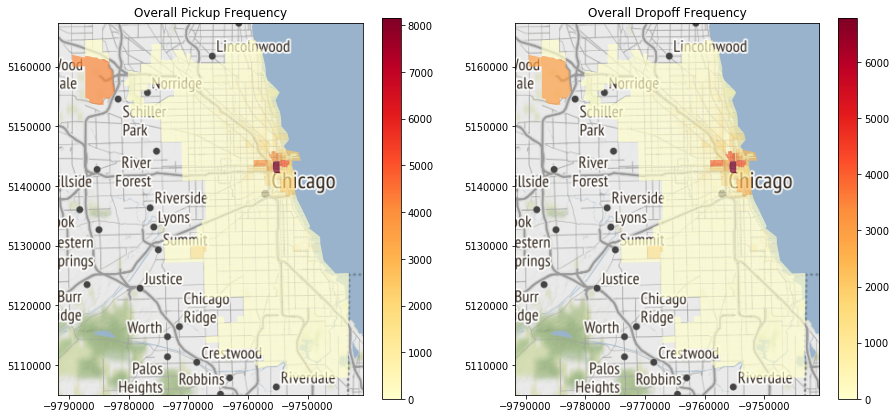

In [12]:
#Bring in geo data for mapping, join to usage df
censtracts=gpd.read_file(os.path.join(datadir,'Boundaries - Census Tracts - 2010.geojson'))
censtracts=censtracts.set_index('geoid10')

usage_by_census_geo=censtracts.join(usage_df,how='left')
usage_by_census_geo['PU_usage']=usage_by_census_geo['PU_usage'].fillna(0)
usage_by_census_geo['DO_usage']=usage_by_census_geo['DO_usage'].fillna(0)
usage_by_census_geo= usage_by_census_geo.to_crs(epsg=3857) #convert wgs84 to wms

#basemap function copied from geopandas documentation
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    ax.axis((xmin, xmax, ymin, ymax))

fig,axes=plt.subplots(1,2, figsize=(15,7))
usage_by_census_geo.plot(column='DO_usage',ax=axes[0],legend=True,alpha=0.7,cmap='YlOrRd')
usage_by_census_geo.plot(column='PU_usage',ax=axes[1],legend=True,alpha=0.7,cmap='YlOrRd')
add_basemap(axes[0], zoom=10)
add_basemap(axes[1], zoom=10)
axes[0].set_title('Overall Pickup Frequency')
axes[1].set_title('Overall Dropoff Frequency')

### What did we learn?  
* The main ride sources of destinations are downtown, O'Hare airport, and to a lesser extent Midway airport
* The most frequently-used pickup locations are the same as the most frequenly-used drop off locations.

## Question 4: How do rideshare patterns vary by weekday and time of day across Chicago?
### Approach:  Generate heat maps of rideshare usage (as a pickup source) by day of week and hour for different neighborhood types:  airports, downtown, neighborhood with nightlife, affluent suburb, college area




In [13]:
#function to plot a heatmap for a census tract
def plotheatmap(tract,name,myax):
    heatdf0=agg_hourly_all.loc[tract]
    heatdf=pd.pivot_table(data=heatdf0,index='DOW',columns='Hour',values='NumRides',aggfunc='sum')
    heatdf.index=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    heatdf=heatdf.fillna(0)
    sns.heatmap(heatdf,ax=myax,cmap='YlOrRd')
    myax.set_title(name)



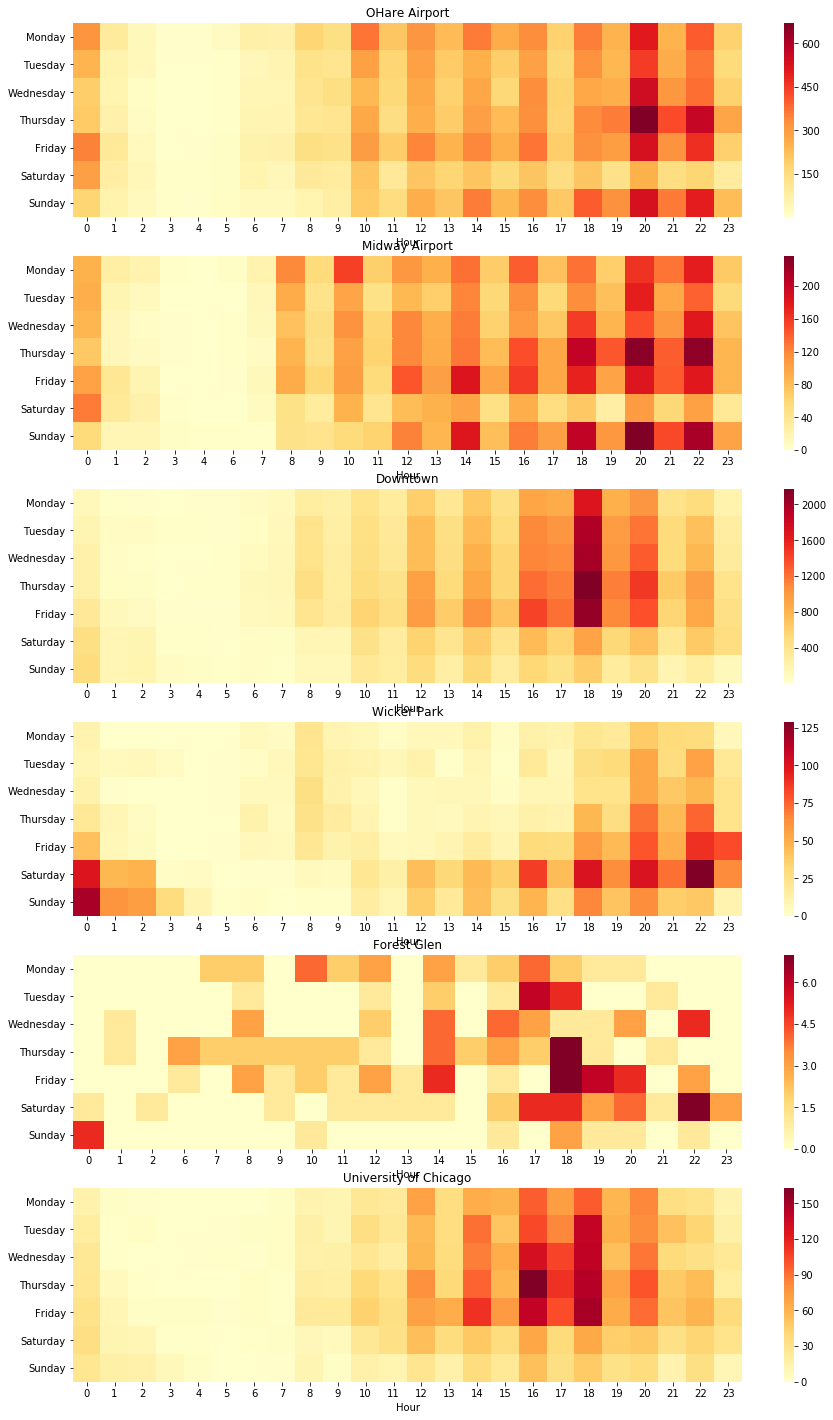

In [14]:
#example tracts
tracts={'OHare Airport':'17031980000','Midway Airport':'17031980100','Downtown':'17031839100','Wicker Park':'17031240300','Forest Glen':'17031120200','University of Chicago':'17031836200'}
tracts_rev={v: k for k, v in tracts.items()} #reverse list for labelling plots
fig,axes=plt.subplots(6,1,figsize=(15,25))
axix=0
for name,tract in tracts.items():
    plotheatmap(tract,name,axes[axix])
    axes[axix].set_title(name)
    axix+=1


### What did we learn?
We see distinct patterns of rideshare pickup activity:
* Airports provide most rides in the evening.  Hottest time is Thursday night.  Light on Saturday.
* Downtown and University provide most rides during the weekday evening commute
* Wicker Park is most active weekend evenings
* The affluent suburb appears to have a more random distribution of rideshare activity, though this may be a sampling effect


## Question 5:  Are rideshare usage patterns affected by weather?
### Approach: 
* Plot time series of daily usage patterns with average daily temperature and total precipitation and look for visual correlations. 
* Plot box plot comparing total daily rides for days with and without precipitation to look for an effect.
* Look at hourly data to see if precipitation effect is more apparent at this level.

Text(0, 0.5, 'Total Precipitation')

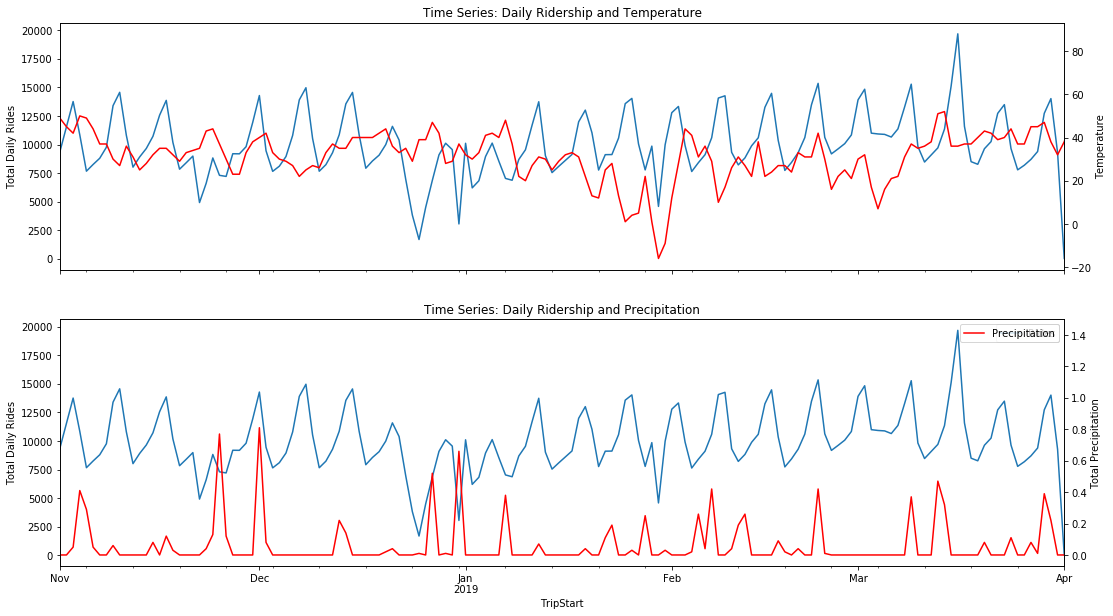

In [15]:
#Look at daily data first:  
all_rides_daily = ridesdf.groupby([ridesdf['TripStart'].dt.date]).size() #sum of trips by start day
all_rides_daily.index=pd.DatetimeIndex(all_rides_daily.index)
weather_daily=pd.read_csv(os.path.join(datadir,'daily_weather_extract.csv'))
weather_daily.index=pd.DatetimeIndex(weather_daily.DATE)
fig, ax = plt.subplots(2,1,figsize=(18,10))
all_rides_daily.plot(ax=ax[0])
ax2 = ax[0].twinx() 
weather_daily['DTemp'].plot(ax=ax2,color='r',legend=False,label='Temperature')
ax[0].set_xlim(all_rides_daily.index.min(),all_rides_daily.index.max())
ax[0].set_title('Time Series: Daily Ridership and Temperature')
ax[0].set_ylabel('Total Daily Rides')
ax2.set_ylabel('Temperature')

all_rides_daily.plot(ax=ax[1],legend='False',label='Rides')
ax3 = ax[1].twinx()
weather_daily['DPrecip'].plot(ax=ax3,color='r',legend='False',label='Precipitation')
ax[1].set_xlim(all_rides_daily.index.min(),all_rides_daily.index.max())
ax[1].set_title('Time Series: Daily Ridership and Precipitation')
ax[1].set_ylabel('Total Daily Rides')
ax3.set_ylabel('Total Precipitation')


In [16]:
# Note we are also seeing some holiday effects, reduced rides over Christmas and Thanksgiving holidays. Peak on the saturday before saint patricks day.
#(City event on 3/16:  river dyeing and parade)
# Possible effect from record-breaking extreme cold event end of January
all_rides_daily.loc[all_rides_daily.index.month==3]

TripStart
2019-03-01    13908
2019-03-02    14837
2019-03-03    10994
2019-03-04    10924
2019-03-05    10887
2019-03-06    10654
2019-03-07    11366
2019-03-08    13278
2019-03-09    15278
2019-03-10     9826
2019-03-11     8468
2019-03-12     9083
2019-03-13     9704
2019-03-14    11352
2019-03-15    15126
2019-03-16    19684
2019-03-17    11586
2019-03-18     8499
2019-03-19     8270
2019-03-20     9629
2019-03-21    10255
2019-03-22    12725
2019-03-23    13489
2019-03-24     9641
2019-03-25     7784
2019-03-26     8188
2019-03-27     8702
2019-03-28     9388
2019-03-29    12728
2019-03-30    14017
2019-03-31     9282
dtype: int64

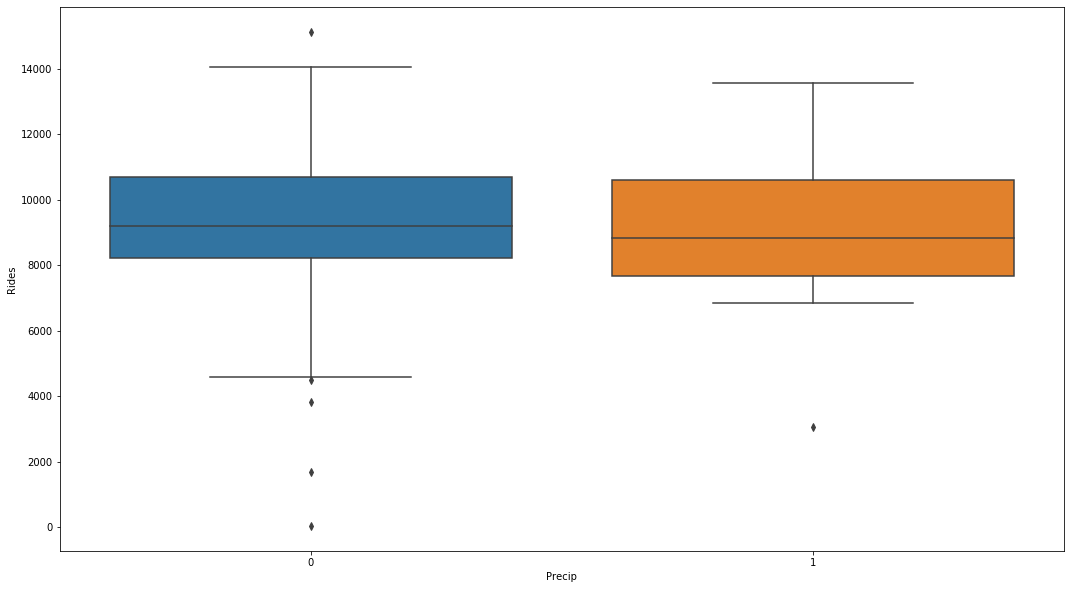

In [17]:
all_rides_daily=all_rides_daily.rename('Rides')
weather_rides_daily=weather_daily.join(all_rides_daily,how='inner')
weather_rides_daily['DOW']=weather_rides_daily.index.dayofweek

weather_rides_daily['Precip'] = weather_rides_daily['DPrecip'].apply(lambda x: 0 if x<0.1 else 1)#where(weather_rides_daily['DPrecip'] ==0, 1) #No rain=0, rain=1
#select a single DOW, monday=0
weekdays=weather_rides_daily.loc[weather_rides_daily.DOW.isin([0,1,2,3,4])]
fig, ax = plt.subplots(1,1,figsize=(18,10))
#ax.scatter(weekdays.DTemp,weekdays.DPrecip,c=weekdays.Rides,cmap='Reds')
ax = sns.boxplot(x="Precip", y="Rides", data=weekdays)

### Hard to see a pattern at the daily level, instead zoom in on system-wide hourly data for weekday evening rush hour and mid-evening periods

Text(0.5, 1.0, 'Mid Evening, Rides per hour')

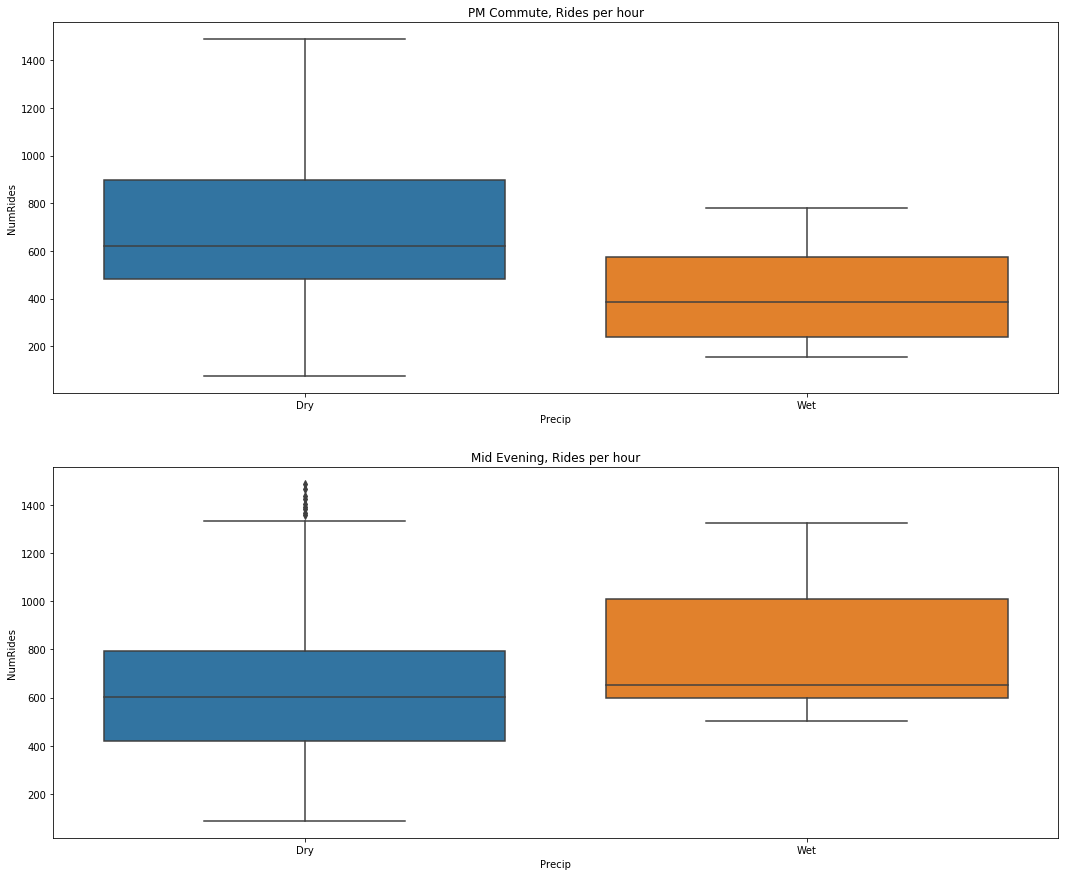

In [18]:
grp_hourly_all=agg_hourly_all.groupby(level=['TripStart']).agg({'Precip':'first','NumRides':'sum'})
grp_hourly_all.head()
weekdays_hrly_commutepm=grp_hourly_all.loc[(grp_hourly_all.index.dayofweek.isin([0,1,2,3,4]))&(grp_hourly_all.index.hour.isin([17,18,19]))]
weekdays_hrly_latenight=grp_hourly_all.loc[(grp_hourly_all.index.dayofweek.isin([0,1,2,3,4]))&(grp_hourly_all.index.hour.isin([20,21,22]))]
fig, ax = plt.subplots(2,1,figsize=(18,15))
sns.boxplot(x="Precip", y="NumRides", data=weekdays_hrly_commutepm,ax=ax[0])
sns.boxplot(x="Precip", y="NumRides", data=weekdays_hrly_latenight,ax=ax[1])
ax[0].set_title('PM Commute, Rides per hour')
ax[1].set_title('Mid Evening, Rides per hour')

### What did we learn?

* There is no easily discernable relationship between rideshare usage and either precipitation or temperature at the daily level, when viewed over the entire dataset.  There is possiblly reduced activity from extreme low temperature (end of January) and heavy snow (Thanksgiving).
* Holidays have a strong effect on activity:  sometimes negative (Christmas) and sometimes positive (St. Patrick's Day).
* If we focus in on the weekday rush hour and mid-evening period we see more discernable effects, with reduced rideshare use during the evening commute when there is precipitation, but increased usage in the 8-10 pm period.
* This pattern suggests people may work from home or use other forms of transportation during rain/snow events to avoid being on the road. But people out later are more inclined to use rideshare.
